## This is an exploratory data analysis of the LibriSpeech and ESC-50 datasets
LibriSpeech contains voice recordings
ESC-50 contains noise recordings

Importing a sample from the dataset and plotting it

Sample Rate : 16000Hz


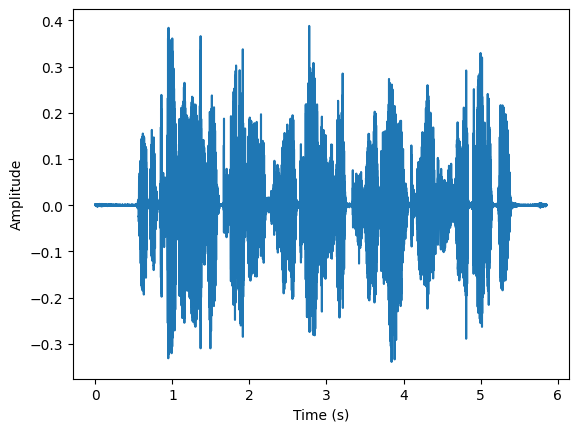

In [16]:
import soundfile
import matplotlib.pyplot as plt
import numpy as np

filepath = "datasets/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac"
signal, audio_samplerate = soundfile.read(filepath)
print(f"Sample Rate : {audio_samplerate}Hz")

fs = 1 / audio_samplerate # sampling frequency
duration = signal.shape[0] * fs # duration of the audio signal
time = np.arange(stop=duration, step=fs)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(time, signal)

Compute and display the stft

Spectrogram shape : (1025, 183)


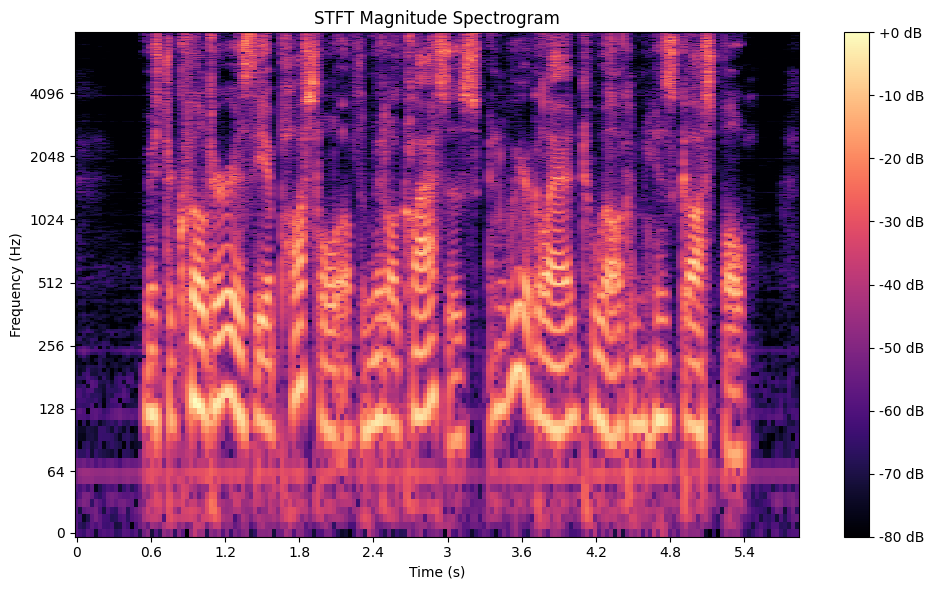

In [17]:
from helpers import plotSpectrogram
import librosa

n_fft = 2048 # number of FFT components
hop_length = n_fft // 4 # number of samples between successive frames

# Compute the Short-Time Fourier Transform (STFT) of the audio signal
stft_signal = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

print(f"Spectrogram shape : {stft_signal.shape}")
plotSpectrogram(stft_signal, audio_samplerate, hop_length)


Can we correctly reconstruct the audio from the stft using the inverse stft ?

Mean Squared Error : 1.976598751829496e-34


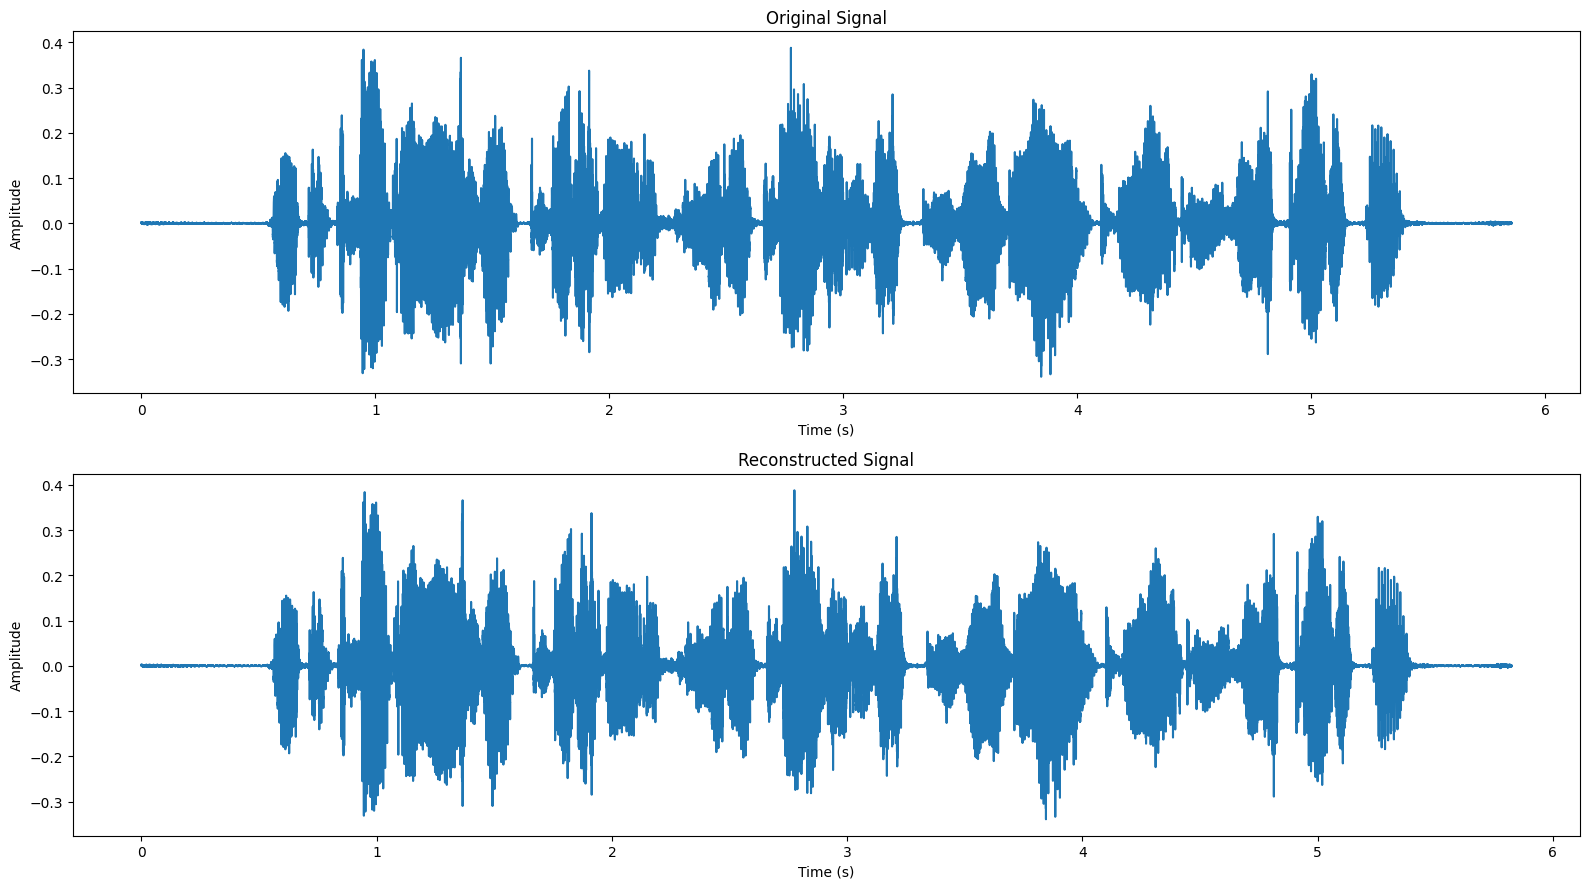

In [18]:
# Calculate the magnitude and phase of the STFT signal
magnitude = np.abs(stft_signal)
phase = np.angle(stft_signal)
stft_reconstructed = magnitude * np.exp(1j * phase)

# Compute the inverse STFT to get the original signal
signal_reconstructed = librosa.istft(stft_signal, hop_length=hop_length)
time = np.arange(stop=duration, step=fs)

# MSE between the original and reconstructed signals
mse = np.mean((signal[:len(signal_reconstructed)] - signal_reconstructed) ** 2) 

print(f"Mean Squared Error : {mse}")
plt.figure(figsize=(16, 9))
# Plot the original signal
plt.subplot(2, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# Plot the reconstructed signal
plt.subplot(2, 1, 2)
plt.plot(time[:len(signal_reconstructed)], signal_reconstructed)
plt.title('Reconstructed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


#### Now we need to create the noisy audios
According to the README, these are the mapping between the target number and the class of each sound:
- target // 10 == 0 => Animals
- target // 10 == 1 => Natural soundscapes & water sounds
- target // 10 == 2 => Human, non-speech sounds
- target // 10 == 3 => Interior/domestic sounds
- target // 10 == 4 => Exterior/urban noises

What we need to do is first to create five folder for each class.
Then for each file in the whole dataset, we will cut it in 1s segments and put these segment in the folder corresponding to the class of the segment.
This will give us some basis to create a training dataset which will consist of the speech recordings to which we will and some noise from 1 or more classes from the dataset.

This also raise the question of the magnitude of the noise that will be added.
It should be high enough to train the model on useful situations but low enough to avoid polluting the audio.
Although maybe this won't make a difference for example if the model rely significately more of the frequency than the magnitude to detect the noise. One thing to consider is that the magnintude of the added noise should be random to prevent the model from potentially detecting noise only by looking at the magnitude. 

datasets/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac
Audio Sample Rate : 16000Hz


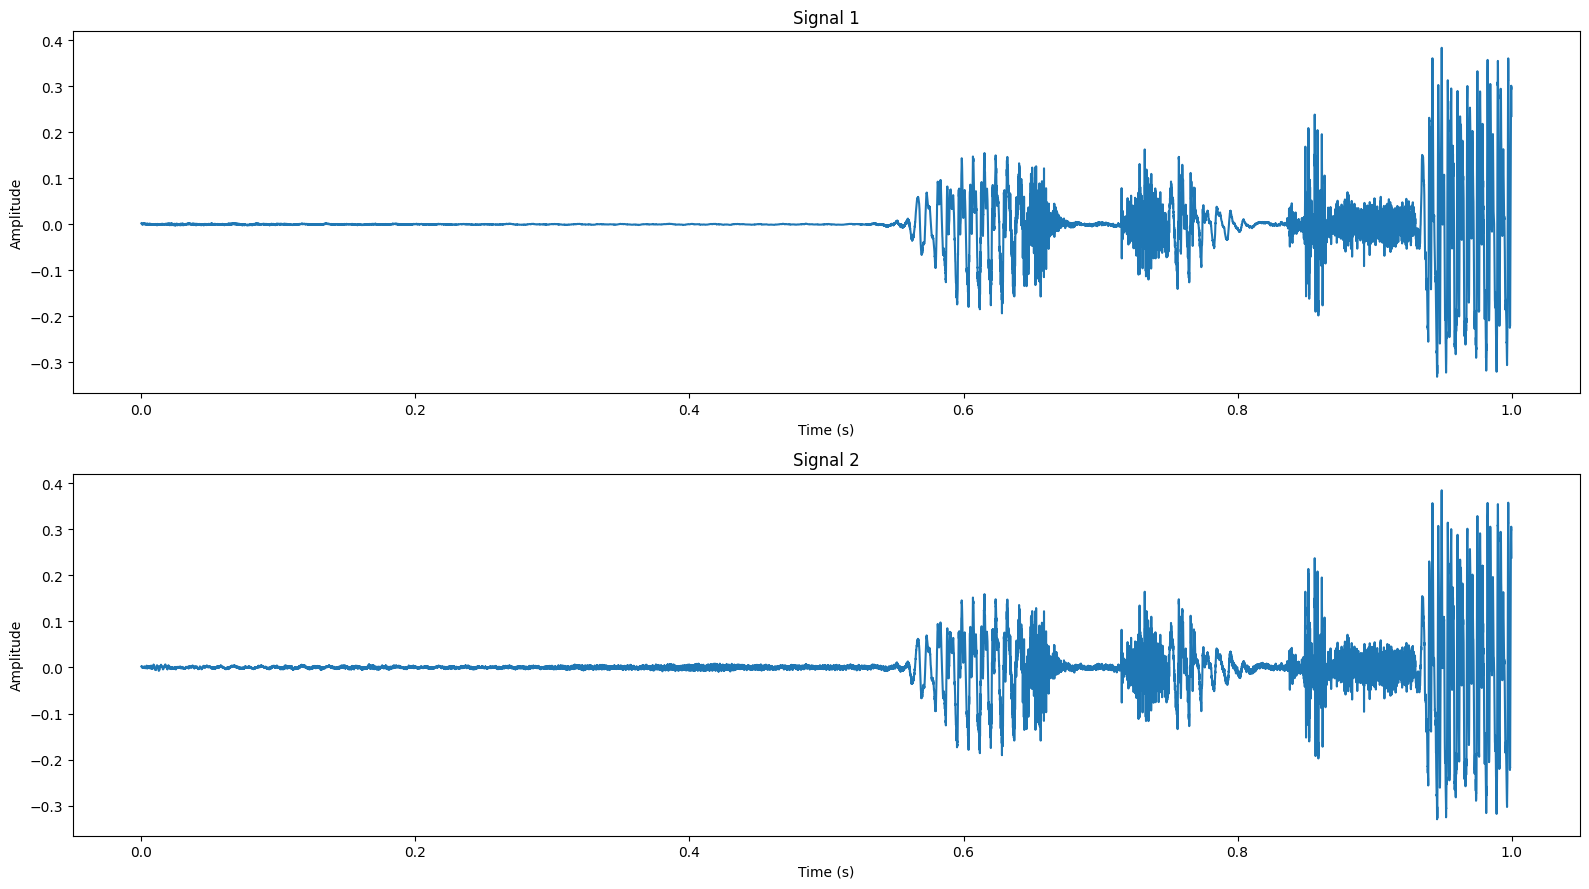

In [19]:
import os
import pandas as pd
from helpers import add_noise, plot_2signals, resample

NOISE_DATASET = "datasets/ESC-50-master/"
audio_dir = os.path.join(NOISE_DATASET, "audio")
labels_path = os.path.join(NOISE_DATASET, "meta/esc50.csv")
labels = pd.read_csv(labels_path)

# Filter the noise dataset to select only interior sounds
interior_noise_labels = labels[labels["target"] // 10 == 3]

audio_file = filepath
print(filepath)
audio_signal, audio_samplerate = soundfile.read(audio_file)
print(f"Audio Sample Rate : {audio_samplerate}Hz")
# Crop the audio signal to the first second
cropped_audio_signal = audio_signal[:audio_samplerate]

noise_file = "datasets/ESC-50-master/audio/1-100210-A-36.wav"
noise_signal, noise_samplerate = soundfile.read(noise_file)
# Take the first second of the noise signal
cropped_noise = noise_signal[:noise_samplerate]
resampled_noise = resample(cropped_noise,noise_samplerate,audio_samplerate)

# Add noise to the cropped audio signal
noisy_audio = add_noise(cropped_audio_signal, resampled_noise)

# Plot the original and noisy signals
plot_2signals(cropped_audio_signal, noisy_audio, audio_samplerate)

# Write the noisy audio to a file
soundfile.write("generated_samples/noise1%.wav", noisy_audio, audio_samplerate)

STFT Shape : (257, 251)


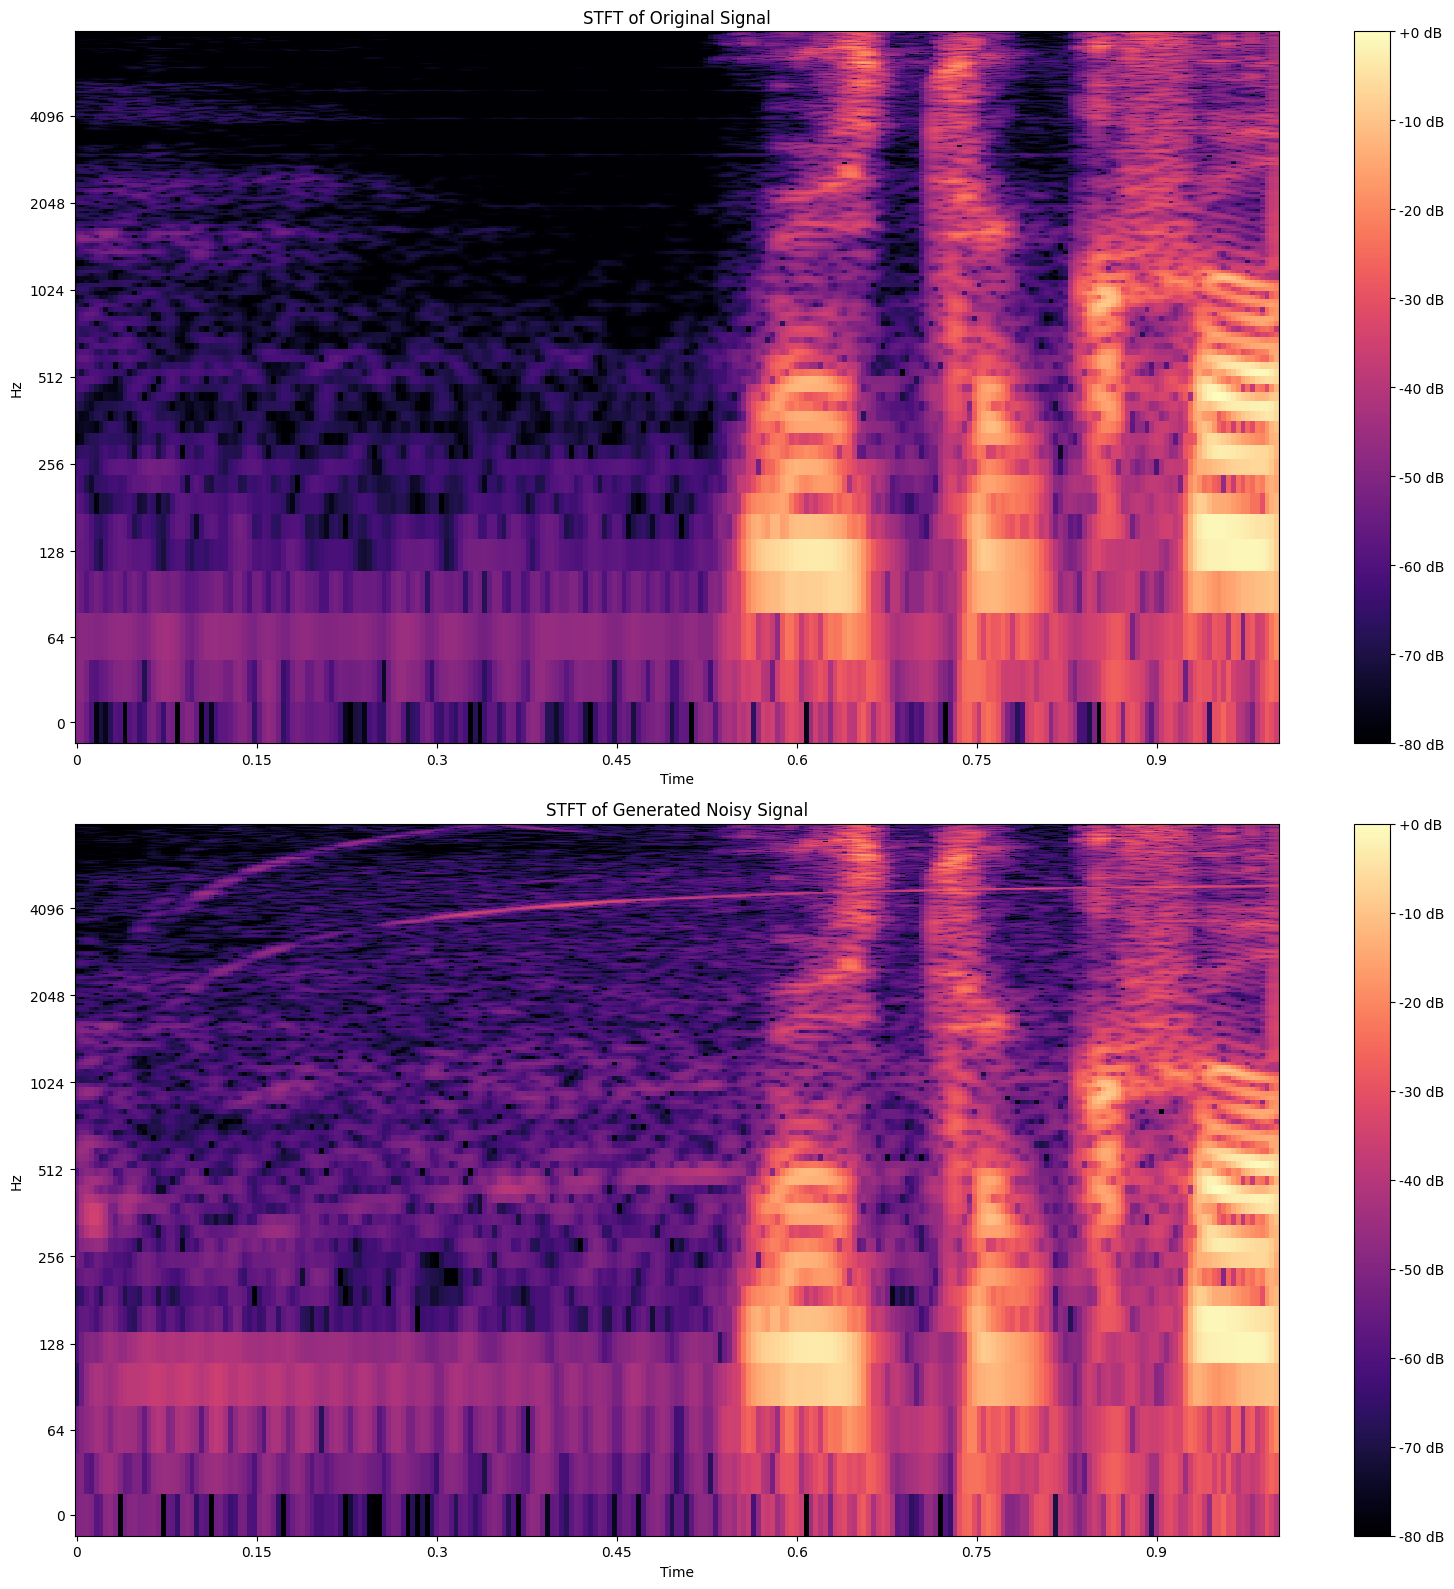

In [20]:
n_fft = 512 # number of FFT components
hop_length = n_fft // 8 # number of samples between successive frames

# Calculate STFT of the original signal
stft_original = librosa.stft(cropped_audio_signal, n_fft=n_fft, hop_length=hop_length)
magnitude_original = np.abs(stft_original)

# Calculate STFT of the generated noisy signal
stft_noisy = librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)
magnitude_noisy = np.abs(stft_noisy)

print(f"STFT Shape : {stft_noisy.shape}")
plt.figure(figsize=(16, 16))

# Original signal STFT
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(magnitude_original, ref=np.max), sr=audio_samplerate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title('STFT of Original Signal')
plt.colorbar(format='%+2.0f dB')

# Generated noisy signal STFT
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(magnitude_noisy, ref=np.max), sr=audio_samplerate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title('STFT of Generated Noisy Signal')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()